# <u>Multi-seed evaluation over Simulation Study</u>

This grid search identifies optimal hyperparameter configurations through a chronological train-validation split. For each candidate configuration, models are trained with early stopping based on validation performance. The best-performing hyperparameter set within each model class is retained for subsequent test set evaluation. y_t serves as the target variable, predicted using lagged input features $\tilde{x}_t$ with a lag window of s=10 time steps.


### <u>Import libraries, modules and models </u>

In [1]:
# Import main libraries
import os, sys, seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import pickle
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec

# Set current and repository working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules
from Modules.Train_Val_Grid import *
from Modules.multi_seed import *

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### <u>Import dataset:</u>

In [2]:
# Import train-validation and test sets

df_train_val = pd.read_csv("../Simulation_Study/simulation_train_val.csv")[["x_t", "y_t"]]
df_test = pd.read_csv("../Simulation_Study/simulation_test.csv")[["x_t", "y_t"]]
true_quantiles_test = pd.read_csv("../Simulation_Study/true_quantiles_test.csv")
lag=10
feature=df_train_val.shape[1]
val_size = 2/7
batch_size = 256


In [3]:
df_train_val.head(2)

,x_t,y_t
0,-0.362942,0.940939
1,0.644323,0.926870


In [4]:
df_test.head(2)

,x_t,y_t
0,0.102668,0.800667
1,-0.249761,0.952148


In [5]:
true_quantiles_test.head(2)

,y_t,q10,q50,q90
0,0.800667,0.902348,1.025422,1.165282
1,0.952148,0.932650,1.046268,1.173726


### <u>Multi seeds evaluation:</u>

In [6]:
# # Compute results for multiple seeds
# results_df_sim, predictions = evaluate_models_multiple_seeds(
#     df_train_val=df_train_val,
#     df_test=df_test,
#     experiment_type='sim',
#     lags=10,
#     val_size=val_size,
#     batch_size=batch_size,
#     seeds=list(range(2, 12)), 
#     true_quantiles_df=true_quantiles_test,
#     results_path="simulation_multi_seed_results_final",
#     device=device
# )

In [7]:
# Compute summary statistics across seeds
results_df_sim = pd.read_csv("simulation_multi_seed_results_final_multiseed_evaluation_20251102_173050.csv")

In [8]:
# Compute summary statistics across seeds
print("\n" + "="*80)
print("SIMULATION STUDY RESULTS (Mean ± Std across 10 seeds)")
print("="*80)

# Define metrics to aggregate
metrics = ['rmse', 'upperquantile_rmse', 'energy_loss', 
           'picp_80', 'sharpness_80', 'q10_rmse', 'q50_rmse', 'q90_rmse', 'duration_sec']

# Aggregate
summary = results_df_sim.groupby('model_name')[metrics].agg(['mean', 'std'])

# Reorder models
ordered_models = ['mlp', 'sequential_mlp', 'engression', 'h_engression', 
                  'sequential_engression', 'h_sequential_engression']
summary = summary.reindex(ordered_models)

# Display with formatting
pd.options.display.float_format = '{:.6f}'.format
summary


SIMULATION STUDY RESULTS (Mean ± Std across 10 seeds)


rmse          upperquantile_rmse           \
                            mean      std               mean      std   
model_name                                                              
mlp                     0.123766 0.000173           0.437873 0.004382   
sequential_mlp          0.123094 0.000066           0.437359 0.001772   
engression              0.124005 0.000152           0.433410 0.005728   
h_engression            0.123950 0.000228           0.438672 0.006251   
sequential_engression   0.123744 0.000214           0.430708 0.011156   
h_sequential_engression 0.123545 0.000253           0.430476 0.012907   

                        energy_loss           picp_80          sharpness_80  \
                               mean      std     mean      std         mean   
model_name                                                                    
mlp                             NaN      NaN      NaN      NaN          NaN   
sequential_mlp                  NaN      NaN      NaN      NaN          NaN   
engression                 0.068118 0.000107 0.783748 0.005395     0.294526   
h_engression               0.068044 0.000142 0.778813 0.006720     0.293719   
sequential_engression      0.067647 0.000109 0.788340 0.006664     0.300647   
h_sequential_engression    0.067551 0.000102 0.789814 0.011503     0.300958   

                                 q10_rmse          q50_rmse          q90_rmse  \
                             std     mean      std     mean      std     mean   
model_name                                                                      
mlp                          NaN      NaN      NaN      NaN      NaN      NaN   
sequential_mlp               NaN      NaN      NaN      NaN      NaN      NaN   
engression              0.003766 0.032303 0.000707 0.018118 0.000757 0.043750   
h_engression            0.004964 0.031697 0.001987 0.018157 0.000372 0.040997   
sequential_engression   0.003807 0.022040 0.000609 0.017929 0.000892 0.032077   
h_sequential_engression 0.008584 0.022530 0.002001 0.017976 0.001191 0.032324   

                                 duration_sec           
                             std         mean      std  
model_name                                              
mlp                          NaN     5.292482 0.538698  
sequential_mlp               NaN    18.261486 3.261638  
engression              0.002565    13.906725 2.708353  
h_engression            0.003148    11.375412 1.724898  
sequential_engression   0.001944    29.938494 4.479699  
h_sequential_engression 0.003531    35.555405 6.911062

### <u>Multi seeds plots:</u>

#### <u>**Determististic model**</u>

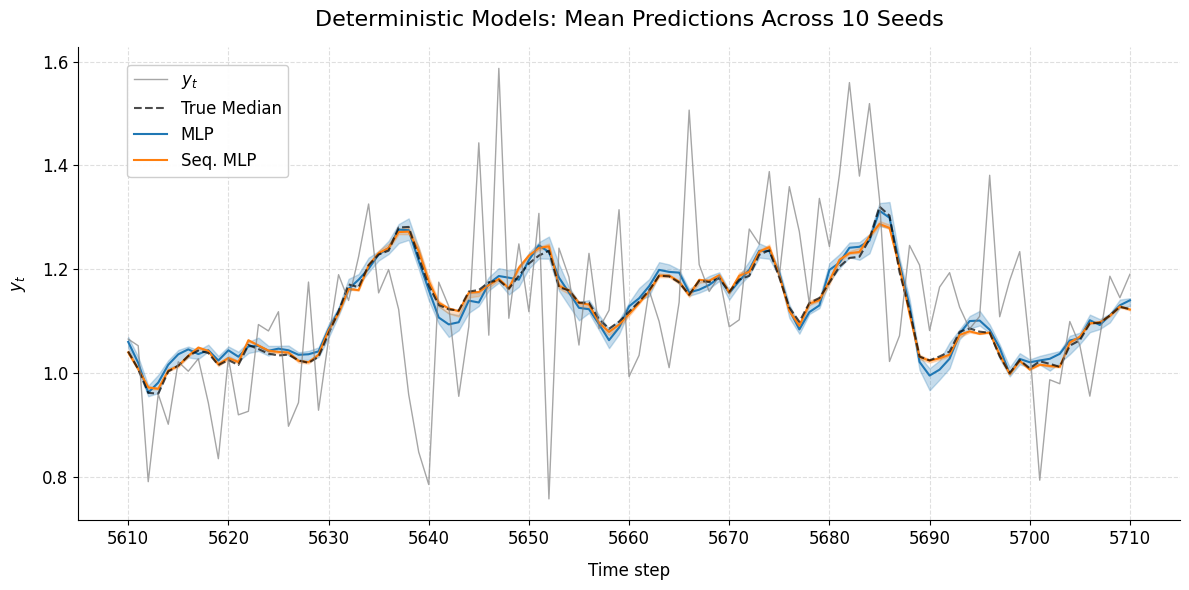

In [9]:
# Load predictions from pickle file
with open('simulation_multi_seed_results_final_predictions_20251102_173050.pkl', 'rb') as f:
    data = pickle.load(f)

predictions = data['predictions']
seeds = data['experiment_info']['seeds']

# Time window
start, window = 5610, 101
end = start + window
time = np.arange(start, end)

# Extract MLP predictions
mlp_preds = []
y_true = None
true_q50 = None
for seed in seeds:
    key = f'mlp_seed{seed}'
    if key in predictions:
        mlp_preds.append(predictions[key]['y_pred'][start:end])
        if y_true is None:
            y_true = predictions[key]['y_true'][start:end]
        # Extract true quantiles if available
        if true_q50 is None and 'true_quantiles' in predictions[key]:
            true_q50 = predictions[key]['true_quantiles']['q50'][start:end]

mlp_preds = np.array(mlp_preds).T

# Extract Sequential MLP predictions  
seq_mlp_preds = []
for seed in seeds:
    key = f'sequential_mlp_seed{seed}'
    if key in predictions:
        seq_mlp_preds.append(predictions[key]['y_pred'][start:end])

seq_mlp_preds = np.array(seq_mlp_preds).T

# Compute statistics across seeds
mlp_median = np.median(mlp_preds, axis=1)
mlp_q10 = np.percentile(mlp_preds, 10, axis=1)
mlp_q90 = np.percentile(mlp_preds, 90, axis=1)

seq_median = np.median(seq_mlp_preds, axis=1)
seq_q10 = np.percentile(seq_mlp_preds, 10, axis=1)
seq_q90 = np.percentile(seq_mlp_preds, 90, axis=1)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# True observations (noisy realizations)
ax.plot(time, y_true, linewidth=1, label='$y_t$', zorder=10, alpha=0.7,
         color='gray')

# True median (ground truth from process)
if true_q50 is not None:
    ax.plot(time, true_q50, 'k--', linewidth=1.5, label='True Median', 
            zorder=9, alpha=0.7)

# MLP - 80% CI (across seeds) - no legend
ax.fill_between(time, mlp_q10, mlp_q90, alpha=0.25, color='#1f77b4', zorder=3)

# MLP - Median (across seeds)
ax.plot(time, mlp_median, color='#1f77b4', linewidth=1.5, 
        label='MLP', zorder=5)

# Seq. MLP - 80% CI (across seeds) - no legend
ax.fill_between(time, seq_q10, seq_q90, alpha=0.25, color='#ff7f0e', zorder=3)

# Seq. MLP - Median (across seeds)
ax.plot(time, seq_median, color='#ff7f0e', linewidth=1.5, 
        label='Seq. MLP', zorder=5)

ax.set_xlabel('Time step', fontsize=12, labelpad=10)
ax.set_ylabel(r'$y_t$', fontsize=12, labelpad=10)
ax.set_title('Deterministic Models: Mean Predictions Across 10 Seeds', fontsize=16, pad=15)
ax.grid(True, alpha=0.4, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))  
ax.tick_params(axis='both', labelsize=12)

# Add y-axis padding for legend space
current_ylim = ax.get_ylim()
y_range = current_ylim[1] - current_ylim[0]

# Place legend after setting ylim
ax.legend(loc='upper left', fontsize=12, framealpha=0.95, bbox_to_anchor=(0.037, 0.98))

plt.tight_layout()
plt.savefig('deterministic_sim_comparison.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### <u>**Stochastic model (mean)**</u>

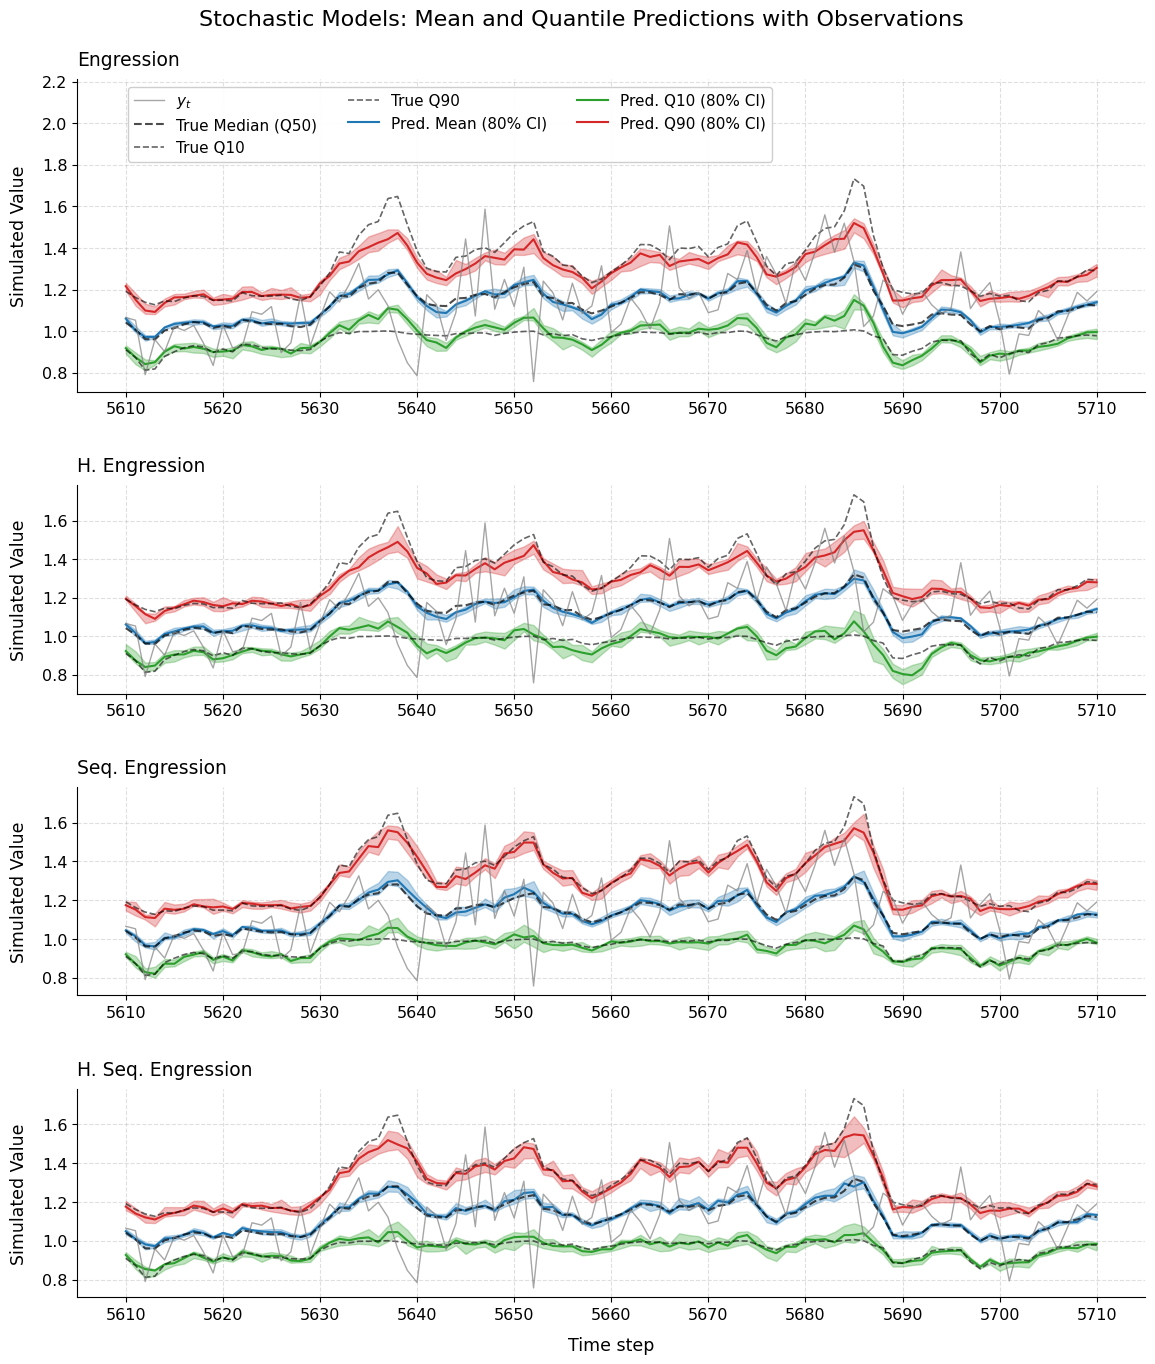

In [10]:
# Time window
start, window = 5610, 101
end = start + window
time = np.arange(start, end)

# Define model configurations
models = [
    ('engression', 'Engression'),
    ('h_engression', 'H. Engression'),
    ('sequential_engression', 'Seq. Engression'),
    ('h_sequential_engression', 'H. Seq. Engression')
]

# Extract true quantiles and observations (same for all models)
true_q10 = None
true_q50 = None
true_q90 = None
y_true = None

# Create subplots
fig = plt.figure(figsize=(12, 14))
gs = fig.add_gridspec(4, 1, height_ratios=[1.5, 1, 1, 1], hspace=0.4, 
                      left=0.08, right=0.97, top=0.92, bottom=0.05)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

for idx, (model_key, model_name) in enumerate(models):
    ax = axes[idx]
    
    # Extract predictions across all seeds for this model
    mean_preds = []
    q10_preds = []
    q90_preds = []
    
    for seed in seeds:
        key = f'{model_key}_seed{seed}'
        if key in predictions:
            pred_data = predictions[key]
            
            # Extract mean prediction (from y_pred) and quantile predictions
            if 'y_pred' in pred_data:
                mean_slice = pred_data['y_pred'][start:end]
                mean_preds.append(np.asarray(mean_slice).ravel())
            if 'y_pred_q10' in pred_data:
                q10_slice = pred_data['y_pred_q10'][start:end]
                q10_preds.append(np.asarray(q10_slice).ravel())
            if 'y_pred_q90' in pred_data:
                q90_slice = pred_data['y_pred_q90'][start:end]
                q90_preds.append(np.asarray(q90_slice).ravel())
            
            # Extract true quantiles and observations
            if true_q10 is None and 'true_quantiles' in pred_data:
                true_q10 = np.asarray(pred_data['true_quantiles']['q10'][start:end]).ravel()
                true_q50 = np.asarray(pred_data['true_quantiles']['q50'][start:end]).ravel()
                true_q90 = np.asarray(pred_data['true_quantiles']['q90'][start:end]).ravel()
            
            # Extract observations 
            if y_true is None and 'y_true' in pred_data:
                y_true = np.asarray(pred_data['y_true'][start:end]).ravel()
    
    # Check if we have data
    if len(mean_preds) == 0 or len(q10_preds) == 0 or len(q90_preds) == 0:
        print(f"Warning: No data found for {model_name}")
        continue
    
    # Stack arrays and compute statistics
    mean_preds = np.vstack(mean_preds)
    q10_preds = np.vstack(q10_preds)
    q90_preds = np.vstack(q90_preds)
    
    # For mean predictions: compute median across seeds and 80% CI
    mean_median = np.median(mean_preds, axis=0).ravel()
    mean_lower = np.percentile(mean_preds, 10, axis=0).ravel()
    mean_upper = np.percentile(mean_preds, 90, axis=0).ravel()
    
    # For quantiles: same as before
    q10_median = np.median(q10_preds, axis=0).ravel()
    q10_lower = np.percentile(q10_preds, 10, axis=0).ravel()
    q10_upper = np.percentile(q10_preds, 90, axis=0).ravel()
    
    q90_median = np.median(q90_preds, axis=0).ravel()
    q90_lower = np.percentile(q90_preds, 10, axis=0).ravel()
    q90_upper = np.percentile(q90_preds, 90, axis=0).ravel()
    
    # Plot observed values (gray line with markers)
    if y_true is not None:
        ax.plot(time, y_true, color='gray', linewidth=1.0, alpha=0.7
                , markersize=2, label='$y_t$', zorder=11)
    
    # Plot true quantiles (black dashed lines)
    if true_q50 is not None:
        ax.plot(time, true_q50, 'k--', linewidth=1.5, label='True Median (Q50)', 
                zorder=10, alpha=0.7)
    if true_q10 is not None:
        ax.plot(time, true_q10, 'k--', linewidth=1.2, label='True Q10', 
                zorder=9, alpha=0.6)
    if true_q90 is not None:
        ax.plot(time, true_q90, 'k--', linewidth=1.2, label='True Q90', 
                zorder=9, alpha=0.6)
    
    # Plot predicted mean with 80% CI - Blue
    ax.fill_between(time, mean_lower, mean_upper, alpha=0.3, color='#1f77b4', 
                    zorder=3)
    ax.plot(time, mean_median, color='#1f77b4', linewidth=1.5, 
            label='Pred. Mean (80% CI)', zorder=5)
    
    # 10% quantile - Green
    ax.fill_between(time, q10_lower, q10_upper, alpha=0.3, color='#2ca02c', 
                    zorder=2)
    ax.plot(time, q10_median, color='#2ca02c', linewidth=1.5, 
            label='Pred. Q10 (80% CI)', zorder=4)
    
    # 90% quantile - Red
    ax.fill_between(time, q90_lower, q90_upper, alpha=0.3, color='#d62728', 
                    zorder=2)
    ax.plot(time, q90_median, color='#d62728', linewidth=1.5, 
            label='Pred. Q90 (80% CI)', zorder=4)
    
    # Formatting
    if idx == 3:  # Only bottom plot
        ax.set_xlabel('Time step', fontsize=12.5, labelpad=10)
    ax.set_ylabel('Simulated Value', fontsize=12.5, labelpad=10)
    ax.set_title(model_name, fontsize=13.5, pad=10, fontweight='normal', loc='left')
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.tick_params(axis='both', labelsize=11.5)
    
    # Padding y-axis of the first subplot (less padding needed now with more space)
    if idx == 0:
        current_ylim = ax.get_ylim()
        y_range = current_ylim[1] - current_ylim[0]
        ax.set_ylim(current_ylim[0], current_ylim[1] + 0.4 * y_range)
    
    # Add legend only to first subplot with updated layout
    if idx == 0:
        ax.legend(loc='upper left', fontsize=11, framealpha=0.95, ncol=3, 
                 bbox_to_anchor=(0.04, 1))

# Add overall title
fig.suptitle('Stochastic Models: Mean and Quantile Predictions with Observations', 
             fontsize=16, y=0.97, fontweight='normal')

plt.savefig('stochastic_sim_mean_quantiles_with_obs.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### <u>**Stochastic model (median + quantiles) in High volatility**</u>

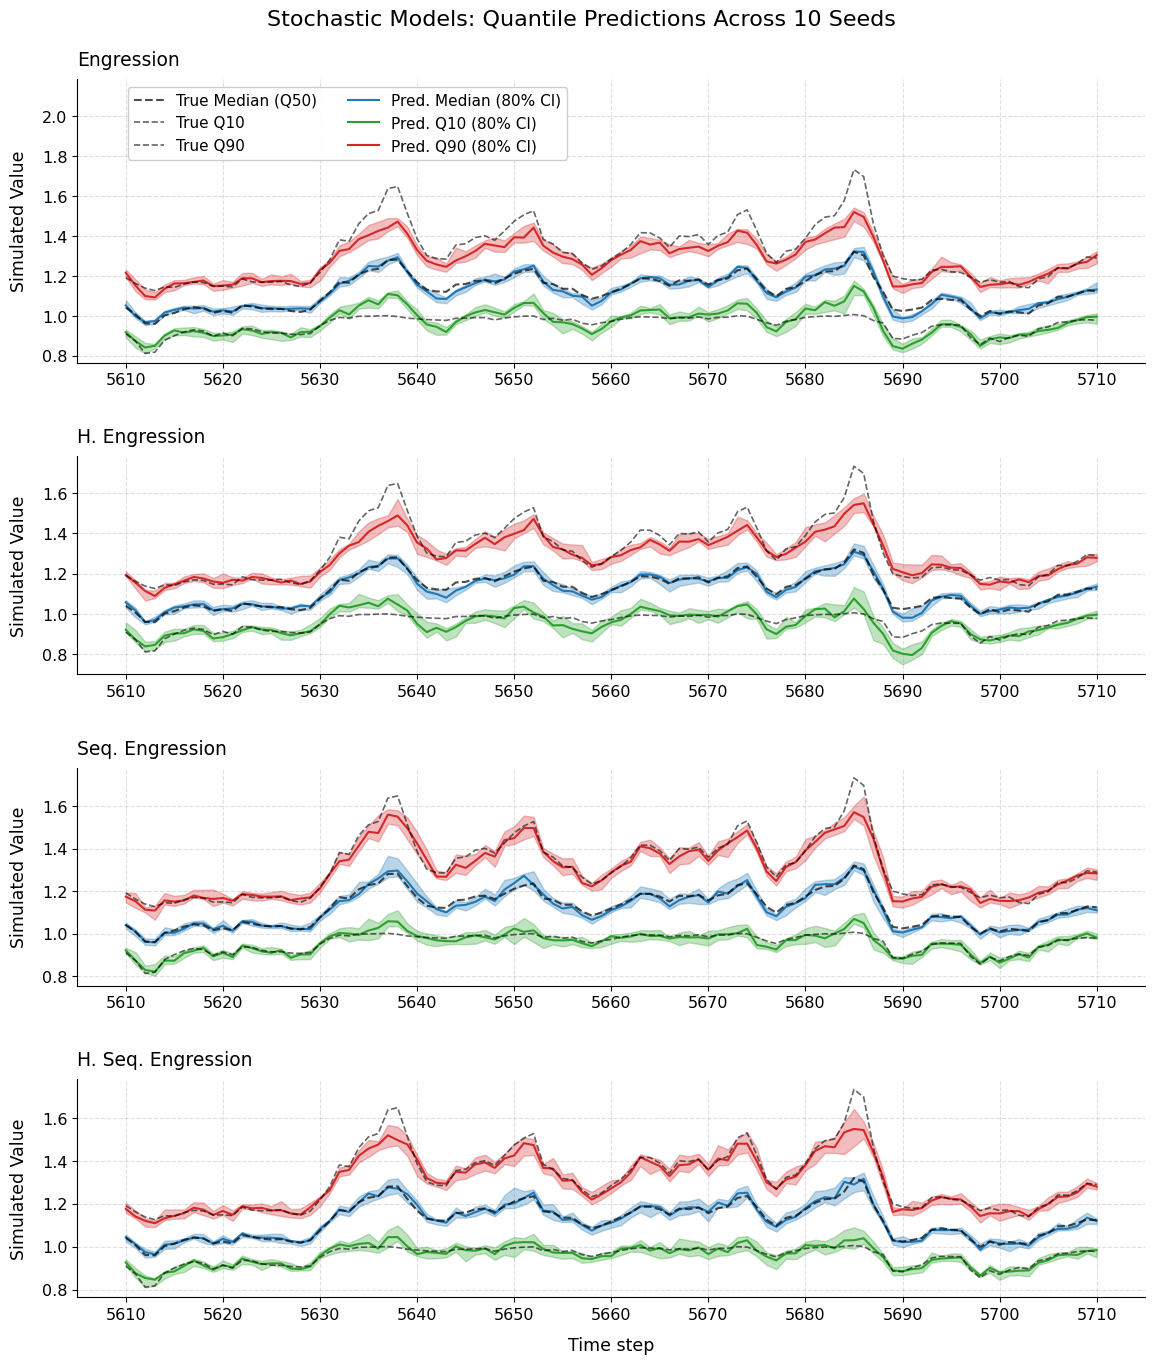

In [11]:
# Time window
start, window = 5610, 101
end = start + window
time = np.arange(start, end)

# Define model configurations
models = [
    ('engression', 'Engression'),
    ('h_engression', 'H. Engression'),
    ('sequential_engression', 'Seq. Engression'),
    ('h_sequential_engression', 'H. Seq. Engression')
]

# Extract true quantiles 
true_q10 = None
true_q50 = None
true_q90 = None

# Create subplots
fig = plt.figure(figsize=(12, 14))
gs = fig.add_gridspec(4, 1, height_ratios=[1.3, 1, 1, 1], hspace=0.4, 
                      left=0.08, right=0.97, top=0.92, bottom=0.05)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

for idx, (model_key, model_name) in enumerate(models):
    ax = axes[idx]
    
    # Extract predictions across all seeds for this model
    q10_preds = []
    q50_preds = []
    q90_preds = []
    
    for seed in seeds:
        key = f'{model_key}_seed{seed}'
        if key in predictions:
            pred_data = predictions[key]
            
            # Extract quantile predictions and ensure they're 1D arrays
            if 'y_pred_q10' in pred_data:
                q10_slice = pred_data['y_pred_q10'][start:end]
                q10_preds.append(np.asarray(q10_slice).ravel())
            if 'y_pred_median' in pred_data:
                q50_slice = pred_data['y_pred_median'][start:end]
                q50_preds.append(np.asarray(q50_slice).ravel())
            if 'y_pred_q90' in pred_data:
                q90_slice = pred_data['y_pred_q90'][start:end]
                q90_preds.append(np.asarray(q90_slice).ravel())
            
            # Extract true quantiles (only once)
            if true_q10 is None and 'true_quantiles' in pred_data:
                true_q10 = np.asarray(pred_data['true_quantiles']['q10'][start:end]).ravel()
                true_q50 = np.asarray(pred_data['true_quantiles']['q50'][start:end]).ravel()
                true_q90 = np.asarray(pred_data['true_quantiles']['q90'][start:end]).ravel()
    
    # Check if we have data
    if len(q10_preds) == 0 or len(q50_preds) == 0 or len(q90_preds) == 0:
        print(f"Warning: No data found for {model_name}")
        continue
    
    # Stack arrays and compute statistics
    q10_preds = np.vstack(q10_preds)
    q50_preds = np.vstack(q50_preds)
    q90_preds = np.vstack(q90_preds)
    
    q10_median = np.median(q10_preds, axis=0).ravel()
    q10_lower = np.percentile(q10_preds, 10, axis=0).ravel()
    q10_upper = np.percentile(q10_preds, 90, axis=0).ravel()
    
    q50_median = np.median(q50_preds, axis=0).ravel()
    q50_lower = np.percentile(q50_preds, 10, axis=0).ravel()
    q50_upper = np.percentile(q50_preds, 90, axis=0).ravel()
    
    q90_median = np.median(q90_preds, axis=0).ravel()
    q90_lower = np.percentile(q90_preds, 10, axis=0).ravel()
    q90_upper = np.percentile(q90_preds, 90, axis=0).ravel()
    
    # Plot true quantiles (black dashed lines)
    if true_q50 is not None:
        ax.plot(time, true_q50, 'k--', linewidth=1.5, label='True Median (Q50)', 
                zorder=10, alpha=0.7)
    if true_q10 is not None:
        ax.plot(time, true_q10, 'k--', linewidth=1.2, label='True Q10', 
                zorder=9, alpha=0.6)
    if true_q90 is not None:
        ax.plot(time, true_q90, 'k--', linewidth=1.2, label='True Q90', 
                zorder=9, alpha=0.6)
    
    # Plot predicted quantiles with 80% CI
    # Median (q50) - Blue
    ax.fill_between(time, q50_lower, q50_upper, alpha=0.3, color='#1f77b4', 
                    zorder=3)
    ax.plot(time, q50_median, color='#1f77b4', linewidth=1.5, 
            label='Pred. Median (80% CI)', zorder=5)
    
    # 10% quantile - Green
    ax.fill_between(time, q10_lower, q10_upper, alpha=0.3, color='#2ca02c', 
                    zorder=2)
    ax.plot(time, q10_median, color='#2ca02c', linewidth=1.5, 
            label='Pred. Q10 (80% CI)', zorder=4)
    
    # 90% quantile - Red
    ax.fill_between(time, q90_lower, q90_upper, alpha=0.3, color='#d62728', 
                    zorder=2)
    ax.plot(time, q90_median, color='#d62728', linewidth=1.5, 
            label='Pred. Q90 (80% CI)', zorder=4)
    
    # Formatting
    if idx == 3:  # Only bottom plot
        ax.set_xlabel('Time step', fontsize=12.5, labelpad=10)
    ax.set_ylabel('Simulated Value', fontsize=12.5, labelpad=10)
    ax.set_title(model_name, fontsize=13.5, pad=10, fontweight='normal', loc='left')
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.tick_params(axis='both', labelsize=11.5)
    
    # Padding y-axis of the first subplot (space legenda)
    if idx == 0:
        current_ylim = ax.get_ylim()
        y_range = current_ylim[1] - current_ylim[0]
        ax.set_ylim(current_ylim[0], current_ylim[1] + 0.4 * y_range)
    
    # Add legend only to first subplot
    if idx == 0:
        ax.legend(loc='upper left', fontsize=11, framealpha=0.95, ncol=2,
                   bbox_to_anchor=(0.04, 1))

# Add overall title
fig.suptitle('Stochastic Models: Quantile Predictions Across 10 Seeds', 
             fontsize=16, y=0.97, fontweight='normal')

plt.savefig('stochastic_sim_quantiles.pdf', bbox_inches='tight', dpi=600)
plt.show()

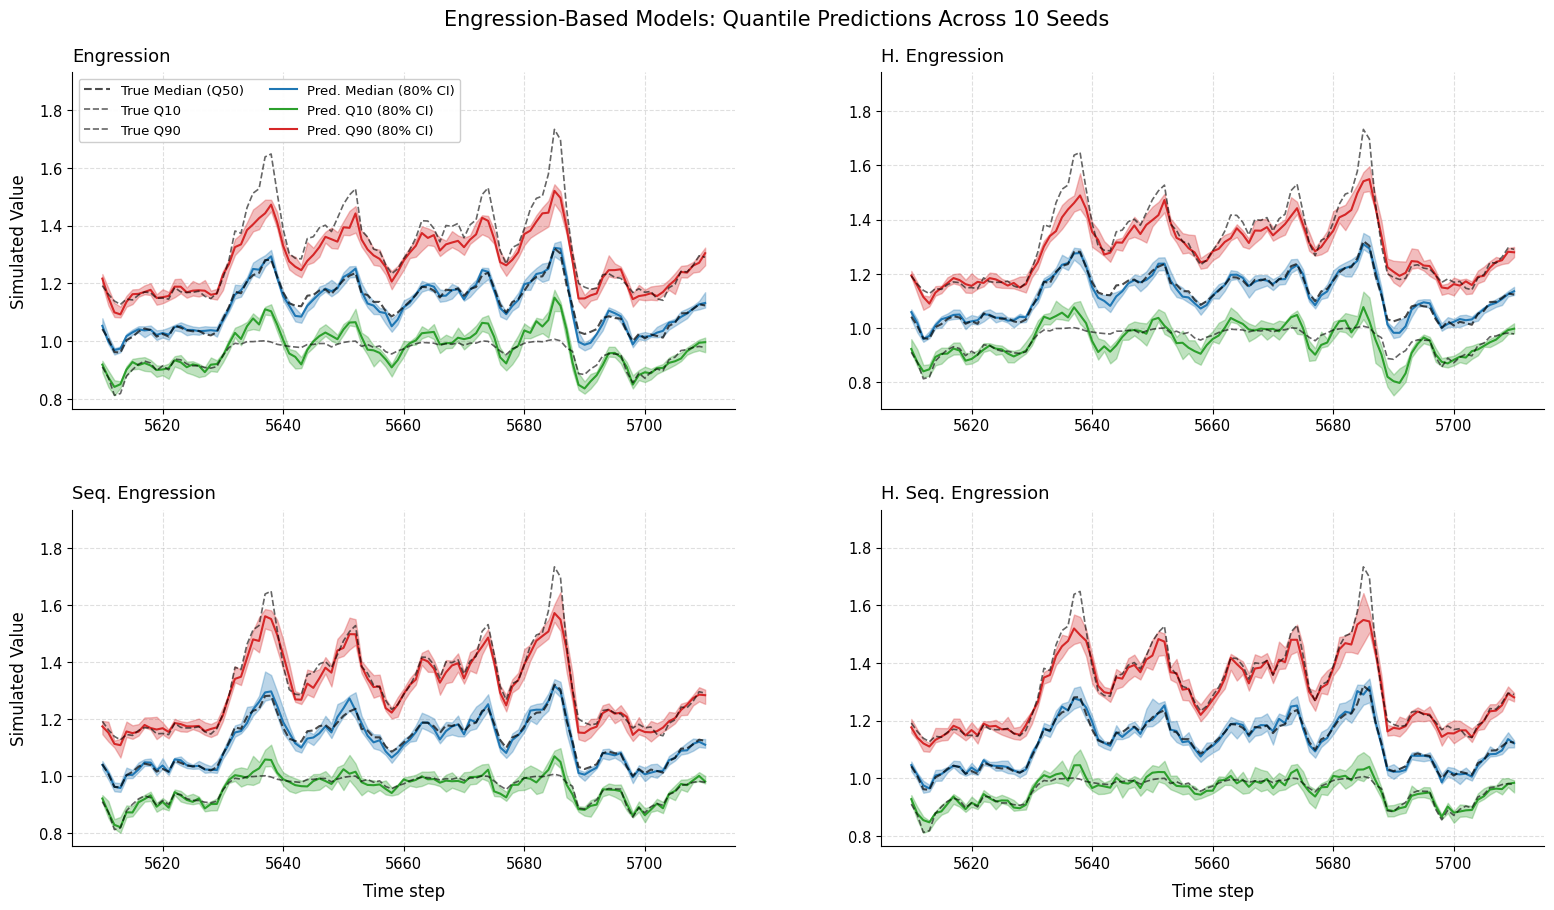

In [22]:
# Define model configurations
models = [
    ('engression', 'Engression'),
    ('h_engression', 'H. Engression'),
    ('sequential_engression', 'Seq. Engression'),
    ('h_sequential_engression', 'H. Seq. Engression')
]

# Extract true quantiles 
true_q10 = None
true_q50 = None
true_q90 = None

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

# Adjust spacing
plt.subplots_adjust(hspace=0.3, wspace=0.22, left=0.06, right=0.98, top=0.93, bottom=0.07)

for idx, (model_key, model_name) in enumerate(models):
    ax = axes[idx]
    
    # Extract predictions across all seeds for this model
    q10_preds = []
    q50_preds = []
    q90_preds = []
    
    for seed in seeds:
        key = f'{model_key}_seed{seed}'
        if key in predictions:
            pred_data = predictions[key]
            
            # Extract quantile predictions and ensure they're 1D arrays
            if 'y_pred_q10' in pred_data:
                q10_slice = pred_data['y_pred_q10'][start:end]
                q10_preds.append(np.asarray(q10_slice).ravel())
            if 'y_pred_median' in pred_data:
                q50_slice = pred_data['y_pred_median'][start:end]
                q50_preds.append(np.asarray(q50_slice).ravel())
            if 'y_pred_q90' in pred_data:
                q90_slice = pred_data['y_pred_q90'][start:end]
                q90_preds.append(np.asarray(q90_slice).ravel())
            
            # Extract true quantiles (only once)
            if true_q10 is None and 'true_quantiles' in pred_data:
                true_q10 = np.asarray(pred_data['true_quantiles']['q10'][start:end]).ravel()
                true_q50 = np.asarray(pred_data['true_quantiles']['q50'][start:end]).ravel()
                true_q90 = np.asarray(pred_data['true_quantiles']['q90'][start:end]).ravel()
    
    # Check if we have data
    if len(q10_preds) == 0 or len(q50_preds) == 0 or len(q90_preds) == 0:
        print(f"Warning: No data found for {model_name}")
        continue
    
    # Stack arrays and compute statistics
    q10_preds = np.vstack(q10_preds)
    q50_preds = np.vstack(q50_preds)
    q90_preds = np.vstack(q90_preds)
    
    q10_median = np.median(q10_preds, axis=0).ravel()
    q10_lower = np.percentile(q10_preds, 10, axis=0).ravel()
    q10_upper = np.percentile(q10_preds, 90, axis=0).ravel()
    
    q50_median = np.median(q50_preds, axis=0).ravel()
    q50_lower = np.percentile(q50_preds, 10, axis=0).ravel()
    q50_upper = np.percentile(q50_preds, 90, axis=0).ravel()
    
    q90_median = np.median(q90_preds, axis=0).ravel()
    q90_lower = np.percentile(q90_preds, 10, axis=0).ravel()
    q90_upper = np.percentile(q90_preds, 90, axis=0).ravel()
    
    # Plot true quantiles (black dashed lines)
    if true_q50 is not None:
        ax.plot(time, true_q50, 'k--', linewidth=1.5, label='True Median (Q50)', 
                zorder=10, alpha=0.7)
    if true_q10 is not None:
        ax.plot(time, true_q10, 'k--', linewidth=1.2, label='True Q10', 
                zorder=9, alpha=0.6)
    if true_q90 is not None:
        ax.plot(time, true_q90, 'k--', linewidth=1.2, label='True Q90', 
                zorder=9, alpha=0.6)
    
    # Plot predicted quantiles with 80% CI
    # Median (q50) - Blue
    ax.fill_between(time, q50_lower, q50_upper, alpha=0.3, color='#1f77b4', 
                    zorder=3)
    ax.plot(time, q50_median, color='#1f77b4', linewidth=1.5, 
            label='Pred. Median (80% CI)', zorder=5)
    
    # 10% quantile - Green
    ax.fill_between(time, q10_lower, q10_upper, alpha=0.3, color='#2ca02c', 
                    zorder=2)
    ax.plot(time, q10_median, color='#2ca02c', linewidth=1.5, 
            label='Pred. Q10 (80% CI)', zorder=4)
    
    # 90% quantile - Red
    ax.fill_between(time, q90_lower, q90_upper, alpha=0.3, color='#d62728', 
                    zorder=2)
    ax.plot(time, q90_median, color='#d62728', linewidth=1.5, 
            label='Pred. Q90 (80% CI)', zorder=4)
    
    # Formatting
    if idx in [2, 3]:  # Bottom row
        ax.set_xlabel('Time step', fontsize=12, labelpad=8)
    if idx in [0, 2]:  # Left column
        ax.set_ylabel('Simulated Value', fontsize=12, labelpad=8)
    
    ax.set_title(model_name, fontsize=13, pad=8, fontweight='normal', loc='left')
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.tick_params(axis='both', labelsize=10.5)
    
    # Add legend only to first subplot (top-left)
    if idx == 0:
        ax.legend(loc='upper left', fontsize=9.5, framealpha=0.95, ncol=2)

# AFTER the loop - adjust y-limits for all subplots to make space for legend
for ax in axes:
    current_ylim = ax.get_ylim()
    y_range = current_ylim[1] - current_ylim[0]
    ax.set_ylim(current_ylim[0], current_ylim[1] + 0.15 * y_range)

# Add overall title
fig.suptitle('Engression-Based Models: Quantile Predictions Across 10 Seeds', 
             fontsize=15, fontweight='normal', y=1)

plt.savefig('stochastic_sim_quantiles_2x2.png', bbox_inches='tight', dpi=300)
plt.show()

#### <u>**Prediction vs Observation across models over extreme events**</u>

99.5% threshold: 1.53
Number of extreme observations: 56


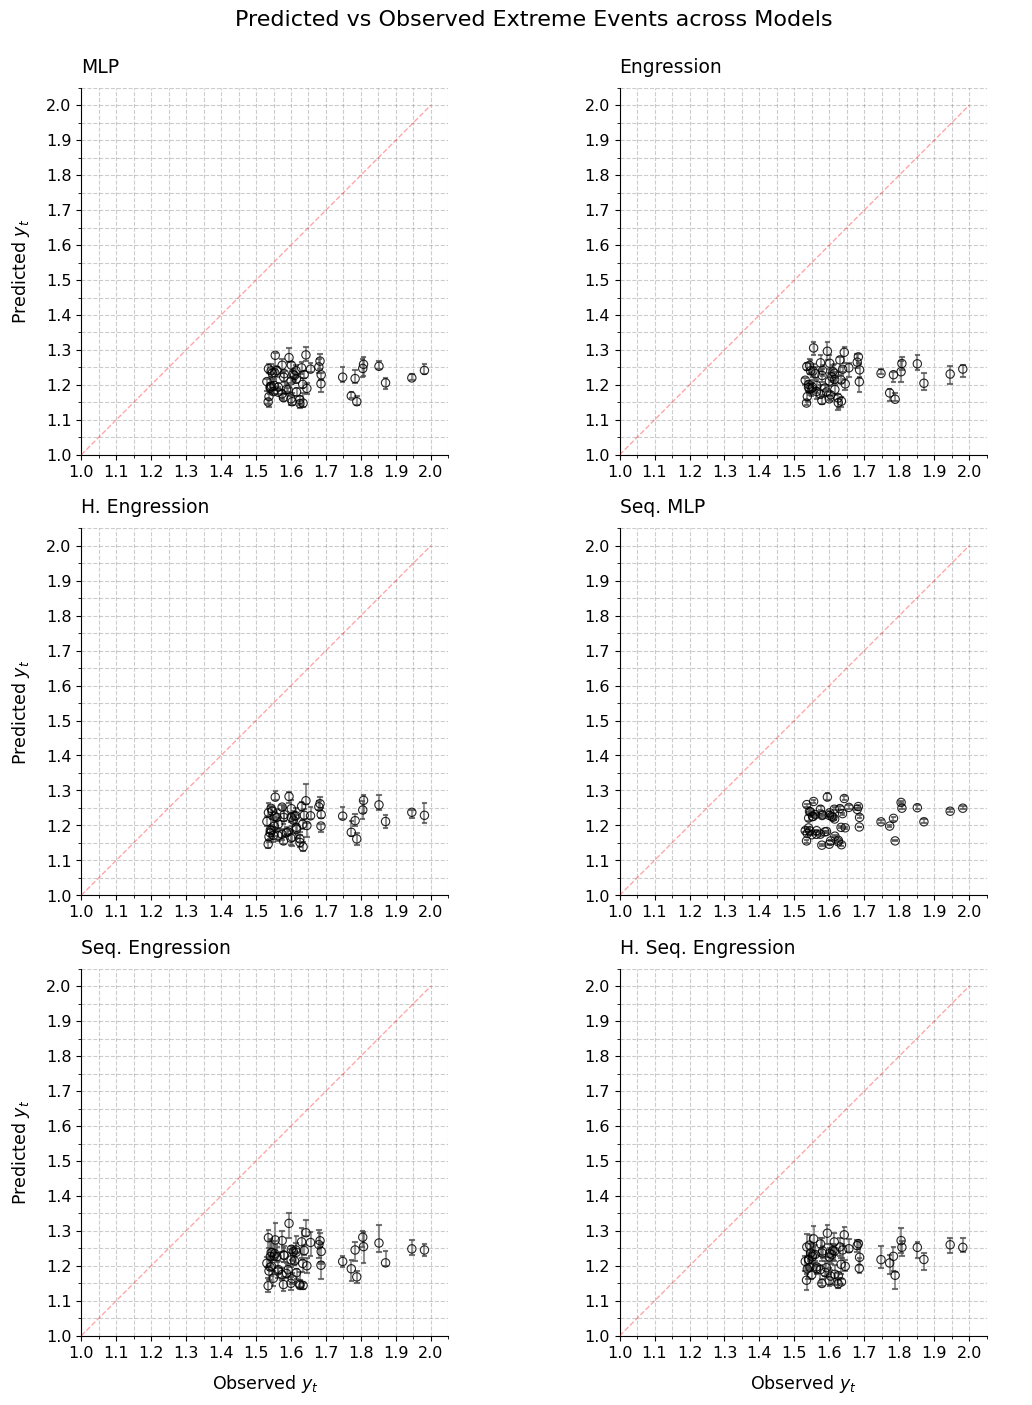

In [13]:
# ============================================================================
# Load all predictions from multi-seed experiment
# ============================================================================

with open('simulation_multi_seed_results_final_predictions_20251102_173050.pkl', 'rb') as f:
    data = pickle.load(f)

predictions = data['predictions']
seeds = data['experiment_info']['seeds']
all_predictions = data['predictions']

# ============================================================================
train_size = int(len(df_train_val) * 5/7)
y_train = df_train_val['y_t'].values[:train_size]
threshold_99_5 = np.quantile(y_train, 0.995)

# ============================================================================
# Aggregate predictions across seeds for each model
# ============================================================================

model_predictions = {}

for pred_key, pred_data in all_predictions.items():
    model_name = pred_data['model_name']
    seed = pred_data['seed']
    
    if model_name not in model_predictions:
        model_predictions[model_name] = {
            'y_true': pred_data['y_true'],
            'y_pred_samples': []
        }
    
    y_pred = pred_data['y_pred']
    model_predictions[model_name]['y_pred_samples'].append(y_pred)

# ============================================================================
# Identify extreme observations (>99.5% quantile)
# ============================================================================

first_model = list(model_predictions.keys())[0]
y_true = model_predictions[first_model]['y_true']
extreme_indices = np.where(y_true >= threshold_99_5)[0]

print(f"99.5% threshold: {threshold_99_5:.2f}")
print(f"Number of extreme observations: {len(extreme_indices)}")

# ============================================================================
# Define model order and names
# ============================================================================

model_order = [
    'mlp',
    'engression',
    'h_engression',
    'sequential_mlp',
    'sequential_engression',
    'h_sequential_engression'
]

model_display_names = {
    'mlp': 'MLP',
    'engression': 'Engression',
    'h_engression': 'H. Engression',
    'sequential_mlp': 'Seq. MLP',
    'sequential_engression': 'Seq. Engression',
    'h_sequential_engression': 'H. Seq. Engression'
}

# ============================================================================
# Define axis limits for each model type
# ============================================================================

# Static models (MLP, Engression, H. Engression) use wider range
static_models = ['mlp', 'engression', 'h_engression']
axis_limits = {}
for model in model_order:
    if model in static_models:
        axis_limits[model] = (1, 2.0)
    else:
        axis_limits[model] = (1, 2.0 )

# ============================================================================
# Define axis limits for each model type
# ============================================================================

# Static models (MLP, Engression, H. Engression) use wider range
static_models = ['mlp', 'engression', 'h_engression']
axis_limits = {}
for model in model_order:
    if model in static_models:
        axis_limits[model] = (1, 2.0)
    else:
        axis_limits[model] = (1, 2.0)

# ============================================================================
# Create scatter plots: predicted vs observed (3 rows, 2 cols)
# ============================================================================

fig = plt.figure(figsize=(12, 13))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1], hspace=0.2, wspace=0.04,
                      left=0.06, right=0.94, top=0.96, bottom=0.0)
axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(2)]

for plot_idx, model_key in enumerate(model_order):
    if model_key not in model_predictions:
        continue
    
    ax = axes[plot_idx]
    pred_data = model_predictions[model_key]
    
    # Stack predictions across seeds
    y_pred_all_seeds = np.array(pred_data['y_pred_samples'])
    y_true_extreme = y_true[extreme_indices]
    y_pred_extreme = y_pred_all_seeds[:, extreme_indices]
    
    # Calculate statistics across seeds
    y_pred_median = np.median(y_pred_extreme, axis=0).ravel()
    y_pred_q10 = np.percentile(y_pred_extreme, 10, axis=0).ravel()
    y_pred_q90 = np.percentile(y_pred_extreme, 90, axis=0).ravel()
    
    # Get axis limits for this model (unpack the tuple)
    xmin, xmax = axis_limits[model_key]
    ymin, ymax = axis_limits[model_key]  
    
    # Add error whiskers (80% CI) - simple vertical lines
    for xt, yp_median, yp_q10, yp_q90 in zip(y_true_extreme, y_pred_median, y_pred_q10, y_pred_q90):
        ax.plot([xt, xt], [yp_q10, yp_q90], color="#505050", alpha=0.6, 
                linewidth=1.5, zorder=2, solid_capstyle='butt')
        # Add caps - adjusted for the 0.5 range
        cap_width = 0.005  # Much smaller for this tight range
        ax.plot([xt-cap_width, xt+cap_width], [yp_q10, yp_q10], color="#505050", alpha=0.8, 
                linewidth=1.5, zorder=2)
        ax.plot([xt-cap_width, xt+cap_width], [yp_q90, yp_q90], color="#505050", alpha=0.8, 
                linewidth=1.5, zorder=2)
    
    # Plot scatter points with better visibility
    ax.scatter(y_true_extreme, y_pred_median, s=36, alpha=0.85, facecolor='none', edgecolor='black',
                zorder=3, linewidths=0.8)
    
    # Perfect prediction line (diagonal)
    ax.plot([xmin, xmax], [ymin, ymax], '--', linewidth=1.0, 
            alpha=0.35, zorder=12, color='red')
    
    # Set consistent limits for all plots
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    
    # Major ticks at 0.1 intervals (with labels)
    major_ticks = np.arange(1, 2.1, 0.1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    
    # Minor ticks at 0.05 intervals (without labels)
    minor_ticks = np.arange(1, 2.1, 0.05)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    
    # Styling for both major and minor grid
    ax.grid(True, which='major', alpha=0.4, linestyle='--', color='gray')
    ax.grid(True, which='minor', alpha=0.4, linestyle='--', color='gray')
    
    # Determine position in grid
    row = plot_idx // 2
    col = plot_idx % 2
    
    # X-axis: Only show axis label for bottom row (row 2), but keep tick numbers for all
    if row < 2:  # Top 4 plots - no axis label
        ax.set_xlabel('')
    else:  # Bottom 2 plots - show axis label
        ax.set_xlabel('Observed $y_t$', fontsize=12.5, labelpad=9)
    
    # Y-axis: Show label on left column
    if col == 0:  # Left column - visible label on left
        ax.set_ylabel('Predicted $y_t$', fontsize=12.5, labelpad=10)
    else:  # Right column - invisible label on right for symmetry
        ax.set_ylabel('')
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('Predicted $y_t$', fontsize=12.5, labelpad=10, color='white')
    
    # Title
    ax.set_title(model_display_names[model_key], fontsize=13.5, pad=11, loc='left')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', labelsize=11.5)


# Overall title - centered without manual adjustment
fig.suptitle('Predicted vs Observed Extreme Events across Models', 
             fontsize=16, y=1.02)

plt.savefig('sim_extreme_predictions_vs_observations.pdf', dpi=600, bbox_inches='tight')
plt.show()